In [4]:
import pandas as pd
import media_mapper as mm
import numpy as np
from sklearn.cluster import KMeans
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score
import nltk
from ast import literal_eval

MAPBOX_API_KEY not found.
TWITTER_CONSUMER_KEY not found.
TWITTER_CONSUMER_SECRET not found.
TWITTER_ACCESS_TOKEN not found.
TWITTER_TOKEN_SECRET not found.
INSTAGRAM_CLIENT_ID not found.
INSTAGRAM_CLIENT_SECRET not found.
INSTAGRAM_ACCESS_TOKEN not found.
FLICKR_API_KEY not found.
FLICKR_API_SECRET not found.


In [667]:
#take out the outlier of the bridge. Also take out the two weird places.
def clean_and_run_kmeans(df, numberofclusters = 6, run_kmeans = True, plt_silouette = True):
    '''Cleans a dataframe, and then calls a a function to run kmeans with sklearn. 
    Arguments:
    1) df: A dataframe with a timestamp, geolabel, and tweet id column. 
    2) numberofclusters: k for Kmeans
    3) run_kmeans: 
        True: If run_kmeans is True, calls the function run_k_means. 
            Returns a three part tuple with the kmeans model, and two dictionaries of geoides and clusters.
        False: If run_kmeans is False, returns an X feature matrix for kmeans analysis.
    4) plt_silouette:
        True: If plot_silouette is true plots the silouette. 
     '''
    df = mm.pipeline.transform_timestamp(df, hour = True, DOW = True)
    #get tweet rate by hour
    dfwk = tweet_rate_by_hour(df, dow= True)
    #pivot table so DOW is columns
    dfwk = pivot_table(dfwk, 'wkday', column_prefix = 'wkday_')
    #get tweet rate by hour
    dfhr = tweet_rate_by_hour(df)
    #pivot table so time of day is columns
    
    ###CHANGE THE hr_bin LABEL SO THE CODE IS MORE READABLE. 
    
    dfhr = pivot_table(dfhr, 'hr_bin', column_prefix = 'hrbin_')
    dfkmeans = pd.merge(dfhr, dfwk, left_on = 'hrbin_', right_on = 'wkday_').drop('wkday_', 1)
    #fill missing values with zeroes 
    dfkmeans.fillna(0, inplace = True)
    #reorder columns for graphing
    ordered_columns = ['hr_bin','wkday_0','wkday_1',
                       'hrbin_morning','hrbin_afternoon',
                       'hrbin_evening','hrbin_latenight','hrbin_dawn',]
    dfkmeans = dfkmeans[ordered_columns]
    if run_kmeans == True:
        kmeans, geoid_dict, cluster_dict = \
        run_k_means(dfkmeans, numberofclusters, plot_silouette = plt_silouette)
        #print the number of blocks assigned to each cluster
        for cluster_id, blocks in cluster_dict.iteritems():
            print cluster_id,'\n number of neighborhoods: ', len(blocks), '\n', \
                dfkmeans[dfkmeans['hrbin_'].isin(blocks)].mean(),'\n','\n'
        return kmeans, geoid_dict, cluster_dict, dfkmeans 
    else:
        #return the dataframe formatted for Kmeans analysis, without running Kmeans
        return dfkmeans


##Unsupervised Clustering with K-Means

In [39]:
def tweet_rate_by_hour(df, dow = False):
    '''
    INPUT: Dataframe with unqiue entries for tweets, and a datetime column. Drops the id column
    
    Calculates tweets rate per hour.

    OUTPUT: If dow is false, will return a dataframe grouped only by hour. 
            If dow is true, will return a dataframe grouped by weekend(0) or weekday (1).
    '''
    #column of ones serves as a counter for number of tweets during group bys
    df['twt_cnt'] = 1
    #group by hour, so we have the total tweets for every hour
    df = df.groupby(['geoid10', 'date', 'hour']).agg(np.sum).reset_index().drop('id', 1)
    #At this point, the twt_count is the number of tweets for every hour 
    df['twt_rate'] = df['twt_cnt']
    
    if dow == False:
        #groupby geoid and hour to get the average rate for every hour
        df = df.groupby(['geoid10', 'hour']).agg(np.mean).reset_index()
        df.drop('DOW', 1, inplace = True)
        df.drop('twt_cnt', 1, inplace = True )  
        df['hr_bin'] = pd.cut(df.hour, bins = 5, labels = ['latenight', 'dawn','morning','afternoon','evening'])
        df = df.groupby(['geoid10', 'hr_bin']).agg(np.mean).reset_index().drop('hour', 1)
   
    else: 
        #group by date for the average tweet rate every day
        df = df.groupby(['geoid10', 'date', 'DOW']).agg(np.mean).reset_index()
        df.drop('hour',1, inplace = True)
        df.drop('twt_cnt',1, inplace = True)    
        df['wknd']=df['DOW'].where(df['DOW'] > 5) 
        df['wkday'] = df['wknd'].isnull().astype(int)
        df.drop('DOW', 1, inplace = True)
        df.drop('wknd', 1, inplace = True)
        #final groupby to get an average count for week days or weekends 
        df = df.groupby(['geoid10', 'wkday']).agg(np.mean).reset_index()
    
    return df

In [40]:
def pivot_table(df, timevariable, column_prefix ):
    '''
    INPUT: Dataframe with three columns: Geoid, tweet rate, and a time variable..
           The argument column_prefix, is used to name the time variable columns.
    OUTPUT: Pivots the table to create a dataframe with geoid as the index, 
            and the time variable as the features.
    '''
    df = df.pivot(index = 'geoid10', columns = timevariable)
    df = df.reset_index(1)
    df = df.rename(columns = lambda x: column_prefix + str(x))
    df.columns = df.columns.droplevel()
    
    return df

In [181]:
def run_kmeans(df, n_clusters)
    k_array = df[['hrbin_afternoon','hrbin_dawn',
     'hrbin_evening',
     'hrbin_latenight',
     'hrbin_morning',
     'wkd_0',
     'wkd_1']].values
    kmeans = KMeans(n_clusters)
    kmeans.fit(X = k_array )
    features = df.columns.tolist()[1:]
    geoids = df['hrbin_']

In [646]:

###get dataframe
df = mm.pipeline.retrieve_sql_tweets('tweets_with_geoV6')
df = mm.pipeline.transform_timestamp(df, hour = True, DOW = True)

#get tweet rate by hour
df_tr_wkdy = tweet_rate_by_hour(df, dow= True)
#pivot table so DOW is columns
df_tr_wkdy = pivot_table(df_tr_wkdy, 'wkday', column_prefix = 'wkday_')

#get tweet rate by hour
df_tr_hr = tweet_rate_by_hour(df)
#pivot table so time of day is columns
df_tr_hr = pivot_table(df_tr_hr, 'hr_bin', column_prefix = 'hrbin_')

dfk = pd.merge(df_tr_hr, df_tr_wkdy, left_on = 'hrbin_', right_on = 'wkd_').drop('wkd_', 1)
#fill missing values with zeroes 
dfk.fillna(0, inplace = True)

run_kmeans(dfk, n_clusters = 6)

# 3. Find the top 10 features for each cluster.

In [23]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print num
    print centroid
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

top features for each cluster:
0
[5 3 2 6 0 1 4]
0: wkd_0, hrbin_latenight, hrbin_evening, wkd_1, hrbin_afternoon, hrbin_dawn, hrbin_morning
1
[3 1 2 4 0 5 6]
1: hrbin_latenight, hrbin_dawn, hrbin_evening, hrbin_morning, hrbin_afternoon, wkd_0, wkd_1
2
[6 2 3 0 5 1 4]
2: wkd_1, hrbin_evening, hrbin_latenight, hrbin_afternoon, wkd_0, hrbin_dawn, hrbin_morning
3
[5 2 3 1 0 4 6]
3: wkd_0, hrbin_evening, hrbin_latenight, hrbin_dawn, hrbin_afternoon, hrbin_morning, wkd_1
4
[2 0 5 3 6 4 1]
4: hrbin_evening, hrbin_afternoon, wkd_0, hrbin_latenight, wkd_1, hrbin_morning, hrbin_dawn
5
[5 2 3 1 0 6 4]
5: wkd_0, hrbin_evening, hrbin_latenight, hrbin_dawn, hrbin_afternoon, wkd_1, hrbin_morning


###put geoids and cluster into a dictionary for storage

In [26]:
from collections import defaultdict
geoidclust = defaultdict(int)
clusters = defaultdict(list)
assigned_cluster = kmeans.transform(k_array).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, k_array.shape[0])[assigned_cluster==i]
    geoids = [dfk.ix[geoindx]['hrbin_'] for geoindx in cluster]
    print len(geoids), 'cluster #', i
    #make a dictionary of cluster as the key, and geoids as the list
    clusters[i] = geoids
    #second dictionary to quickly look up what cluster each geoid belongs to
    for geo in geoids:
        geoidclust[geo] = i
   

1582 cluster # 0
1 cluster # 1
2094 cluster # 2
1 cluster # 3
1 cluster # 4
116 cluster # 5


In [346]:
#save clusters to a csv
import csv
with open('kmeans_round1_clustdict.csv', 'wb') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, clusters.keys())
    w.writeheader()
    w.writerow(clusters)

###How do they Map?

In [28]:
#add geocolumn 
dfk['geoid10'] = dfk['hrbin_']
#add tweetcount as average value
dfk['tweetcnt'] = dfk[['wkd_0', 'wkd_1','hrbin_morning','hrbin_afternoon','hrbin_evening''hrbin_latenight', 'hrbin_dawn']].mean(axis = 1)

In [39]:

###exists in pipeline. use pipeline
def merge_shapes_with_dataframe(df):
    '''imports sql shape files for san francisco. Adds them to a dataframe based on the shared 'geoid10' column.
    Also assmes a 'tweetcnt' column. Returns the new dataframe'''
    ###Retrieve the Shape Files for Each Block:
    geodf = pd.read_csv('/Users/christy/Documents/root/repos/media_mapper/data_pipeline/data/intermediate_data/sf_only_sql_shapes.csv')
    #format the dataframe
    geodf['geoid10'] = geodf.geoid10.astype('str')
    geodf.drop('Unnamed: 0', axis = 1, inplace = True)
    
    df['geoid10'] =df['geoid10'].apply(lambda x: x[1:])
    #create a new dataframe 
    df = pd.merge(geodf, df, on='geoid10', how='outer')
    #fill no tweets with a zero value
    df.tweetcnt.fillna(0, inplace = True)
    #drop empty hour columns
    return df


In [41]:
#format geocolumn for mergind 
dfk['geoid10'] =dfk['geoid10'].apply(lambda x: x[1:])
geodf = merge_shapes_with_dataframe(dfk)
#optional color pallet
colors = ['#c6f50f', '#66cdaa', '#ffa500', '#f67453', '#f6c653', '#ab9eba']
#add color column based on values 
mapdf['hexcolor'] =mapdf["hrbin_"].apply(lambda x:colors[geoidclust[x]].upper())
mapdf['cluster'] = mapdf['hrbin_'].apply(lambda x: str(geoidclust[x]))


In [115]:
#right now I am not using the cluster color 

def add_properties_geo(row):
    '''Creates the properties geoid, tweetcnt, cluster number'''
    geoid = row['geoid10']
    tweetrate = row['tweetcnt']
    hexcolor = row['hexcolor']
    cluster = row['cluster']
    geo_json = {"type": "Feature", "geometry": json.loads(row['geometry']), "properties": {'geoid': geoid ,'tweetrate': tweetrate, 'cluster': cluster , 'hexcolor' : hexcolor}}
    return geo_json

def dataframe_to_geojson(df, outfilename):
    '''Takes in a dataframe with a count, geoid10, and list of tokens. Dumps it into a json geojason file'''
    df['geoid10'] = df['geoid10'].astype('str')
    df["tweetcnt"] = df['tweetcnt'].astype('str')
    list_to_export = []
    for idx, row in df.iterrows():
        list_to_export.append(add_properties_geo(row))
    with open(outfilename, 'w') as outfile:
        json.dump(list_to_export, outfile)

In [117]:
dataframe_to_geojson(mapdf, 'map_making/clusters/data/clustergeo.json')

/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### what did it cluster on?

####Round 1:

In [140]:
clusters[1]

['060759804011003']

In [137]:
for k, v in clusters.iteritems():
    print k,'\n number of neighborhoods: ', len(v), '\n', dfk[dfk['hrbin_'].isin(v)].mean(),'\n','\n'

0 
 number of neighborhoods:  1582 
hrbin_afternoon    1.043457
hrbin_dawn         0.750566
hrbin_evening      1.074981
hrbin_latenight    1.096141
hrbin_morning      0.491886
wkd_0              1.605076
wkd_1              1.067310
dtype: float64 


1 
 number of neighborhoods:  1 
hrbin_afternoon    83.581667
hrbin_dawn         86.952941
hrbin_evening      84.998214
hrbin_latenight    88.728333
hrbin_morning      84.970588
wkd_0              82.623853
wkd_1              62.680556
dtype: float64 


2 
 number of neighborhoods:  2094 
hrbin_afternoon    0.421302
hrbin_dawn         0.189490
hrbin_evening      0.483564
hrbin_latenight    0.447790
hrbin_morning      0.163801
wkd_0              0.244269
wkd_1              0.943002
dtype: float64 


3 
 number of neighborhoods:  1 
hrbin_afternoon    15.402857
hrbin_dawn         25.400000
hrbin_evening      32.708571
hrbin_latenight    30.120000
hrbin_morning       1.416667
wkd_0              40.571429
wkd_1               1.000000
dtype: flo

wait. so how are these three clusters different?

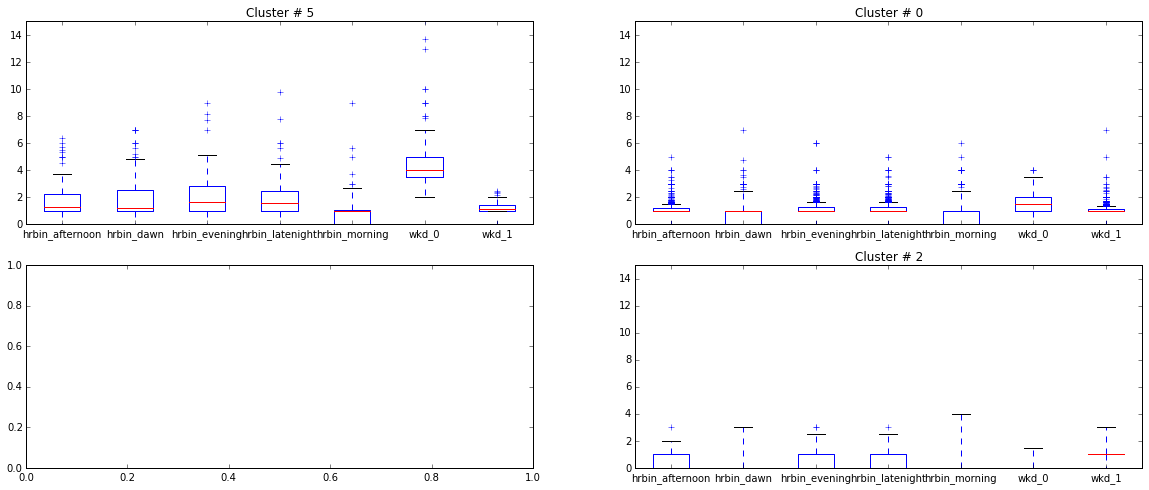

In [180]:


fig, axes = plt.subplots(nrows=2, ncols=2)
cluster5 = clusters[5]
dfk[dfk['hrbin_'].isin(cluster5)].plot(kind = 'box', title = 'Cluster # 5', figsize = (20,8),ylim = (0,15),ax=axes[0,0])

cluster5 = clusters[0]
dfk[dfk['hrbin_'].isin(cluster5)].plot(kind = 'box', title = 'Cluster # 0', figsize = (20,8), ylim = (0,15), ax=axes[0,1])

cluster5 = clusters[2]
dfk[dfk['hrbin_'].isin(cluster5)].plot(kind = 'box', title = 'Cluster # 2', figsize = (20,8), ylim = (0,15), ax=axes[1,1])

##Take out the outliers found by kmeans. Rerun to see if can improve clusters.

Filter out outliers:
    
 - Remove the two geoids with weird patterns relative to thier location.
 - Take out golden gate park during the time when the music festival ocured.

In [670]:
#take out the outlier of the bridge. Also take out the two weird places.
def clean_and_run_kmeans_modified(df, numberofclusters = 6, run_kmeans = True, plt_silouette = True, remove_oddpoints = True):
    '''Cleans a dataframe, and then calls a a function to run kmeans with sklearn. 
    Has Special additions to take out outliers I previously found.
    Arguments:
    1) df: A dataframe with a timestamp, geolabel, and tweet id column. 
    2) numberofclusters: k for Kmeans
    3) run_kmeans: 
        True: If run_kmeans is True, calls the function run_k_means. 
            Returns a three part tuple with the kmeans model, and two dictionaries of geoides and clusters.
        False: If run_kmeans is False, returns an X feature matrix for kmeans analysis.
    4) plt_silouette:
        True: If plot_silouette is true plots the silouette. 
    5) remove_oddpoints: If true, remove geoids with unusual tweeting patterns
        as uncovered by KMeans. Also replaced tweets located in the water
        onto the city. 
     '''
    #get datetime columns to help with cleaning
    df =mm.pipeline.transform_timestamp(df, hour = True, DOW = True)
    
    #filter out the outliers
    #get rid of golden gate park during the music festival
    nogg = df[(df['geoid10']!= '060759803001030')]
    gg = df[(df['geoid10']== '060759803001030')]
    ggdf = pd.concat([nogg, gg[(gg['time'].dt.day > 10) | (gg['time'].dt.month < 8)]])
    #get rid of the other two strange values
    ggdf = ggdf[(ggdf['geoid10']!= '060750201001001')]
    ggdf = ggdf[(ggdf['geoid10']!= '060759804011003')]
    
    df =ggdf
    
    dfwk = tweet_rate_by_hour(df, dow= True)
    #pivot table so DOW is columns
    dfwk = pivot_table(dfwk, 'wkday', column_prefix = 'wkday_')
    #get tweet rate by hour
    dfhr = tweet_rate_by_hour(df)
    #pivot table so time of day is columns
    dfhr = pivot_table(dfhr, 'hr_bin', column_prefix = 'hrbin_')
    dfkmeans = pd.merge(dfhr, dfwk, left_on = 'hrbin_', right_on = 'wkday_').drop('wkday_', 1)
    #reorder the columns 
    dfkmeans = dfkmeans[['hrbin_','wkday_0','wkday_1','hrbin_morning','hrbin_afternoon','hrbin_evening',
     'hrbin_latenight','hrbin_dawn']]
    #fill missing values with zeroes 
    dfkmeans.fillna(0, inplace = True)
    if run_kmeans == True:
        kmeans, geoid_dict, cluster_dict = run_k_means(dfkmeans, numberofclusters, plot_silouette = plt_silouette)
        for k, v in cluster_dict.iteritems():
            print k,'\n number of neighborhoods: ', len(v), '\n', dfkmeans[dfkmeans['hrbin_'].isin(v)].mean(),'\n','\n'
        return kmeans, geoid_dict, cluster_dict, dfkmeans 
    else:
        return dfkmeans


In [657]:
def run_k_means(df, numberclusters, geoidlabel ='hrbin_', plot_silouette = True):
    '''Uses sklearn to run kmeans. 
    Arguments:
    1) df: A dataframe with a geoid column
    2) geoidlabel: the label of the geoid column. 
    3) plot_silouette: whether or not to plot the silouettes of each cluster
    Returns a three part tuple:
    1) the kmeans sklearn model 
    2) a dictionary with geoids as the key, and the cluster as the value
    3) a dictionary with clusters as the key, and a list of related geoids as the value'''
    
    #model a new k means. Turn the dataframe into an array.
    x = df[['wkday_0','wkday_1','hrbin_morning',
            'hrbin_afternoon','hrbin_evening',
             'hrbin_latenight','hrbin_dawn']].values
    kmeans = KMeans(n_clusters = numberclusters)
    kmeans.fit(X = x )
    features = df.columns.tolist()[1:]
    geoids = df[geoidlabel]
    
    #store values in a dictionary
    geoid_dict = defaultdict(int)
    cluster_dict = defaultdict(list)
    
    #EXPLAIN WHAT THIS FUNCTION IS DOING
    assigned_cluster = kmeans.transform(x).argmin(axis=1)
    
    for i in range(kmeans.n_clusters):
        cluster = np.arange(0, x.shape[0])[assigned_cluster==i]
        geoids = [df.ix[geoindx]['hrbin_'] for geoindx in cluster]
        print len(geoids), 'cluster #', i
        #make a dictionary with cluster as the key, and geoids as the list
        cluster_dict[i] = geoids
        #second dictionary to quickly look up what cluster each geoid belongs to
        for geo in geoids:
            geoid_dict[geo] = i
    if  plot_silouette == True:
        plot_cluster_silouette_values(X, assigned_cluster, n_clusters)
    return kmeans, geoid_dict, cluster_dict,

In [658]:
def plot_silhoette_for_ks(cluster_scores):
    #######edit this to include why you waould want to graph silouette scores
    '''Takes as an argument of list of tuples. 
    The first value is the number of clusters run through k means.
    The second item in the tuple is the corresponding average silouettescore.
    Plots a scatter plot.'''
    x = [item[0] for item in cluster_scores] #the number of clusters
    y = [item[1] for item in cluster_scores] #the average silouette score 
    plt.plot(x, y, 'o')
    plt.ylim(0, 1)
    plt.xlabel('number of clusters')
    plt.ylabel('average silouette score')


def determine_k_silhoette(X, range_n_clusters= [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):
    '''From Sklearn: Silhoette coefficients (as these values are referred to as) 
    near +1 indicate that the sample is far away from the neighboring clusters. 
    A value of 0 indicates that the sample is on or very close to the decision boundary 
    between two neighboring clusters and negative values indicate that those samples might 
    have been assigned to the wrong cluster.
    
    
    SAY MODIFIED FROM SKLEARN, give URL'''

    cluster_scores = []
    
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        cluster_scores.append((n_clusters, silhouette_avg))

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.show()
    plot_silhoette_for_ks(cluster_scores)


In [659]:
def plot_cluster_silouette_values (X, cluster_labels, n_clusters):
    '''Plots the average silouette value for each unique cluster found by k_means.
    Arguments:
    X: the feature matrix for Kmeans
    cluster_labels: the predicted cluster labels assiged by Kmeans algorithm
    n_clusters: the number of clusters used for Kmeans 8'''

    fig, (ax1) = plt.subplots(1, 1) 
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    ax1.set_title("silhouette plot clusters.")
    ax1.set_xlabel("silhouette coefficient values")
    ax1.set_ylabel("cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

####Check Number of Clusters for K Means with Silouette Score

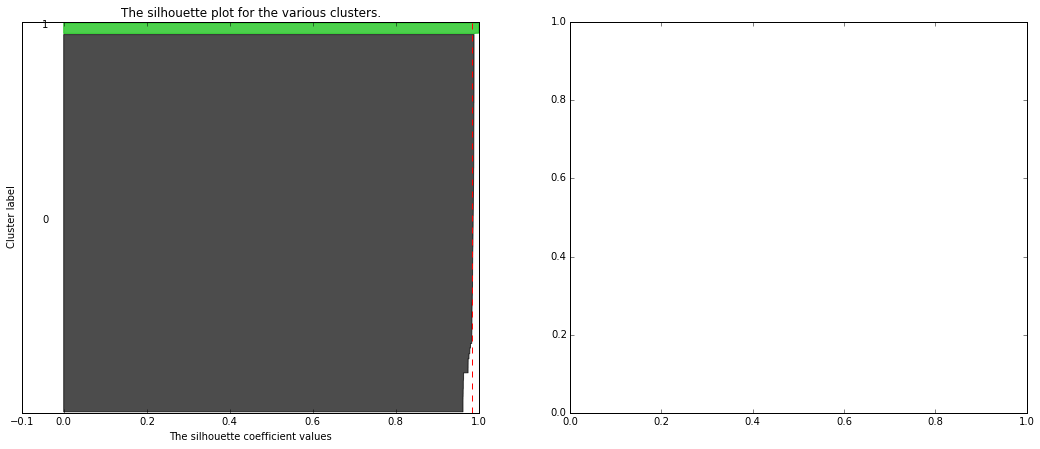

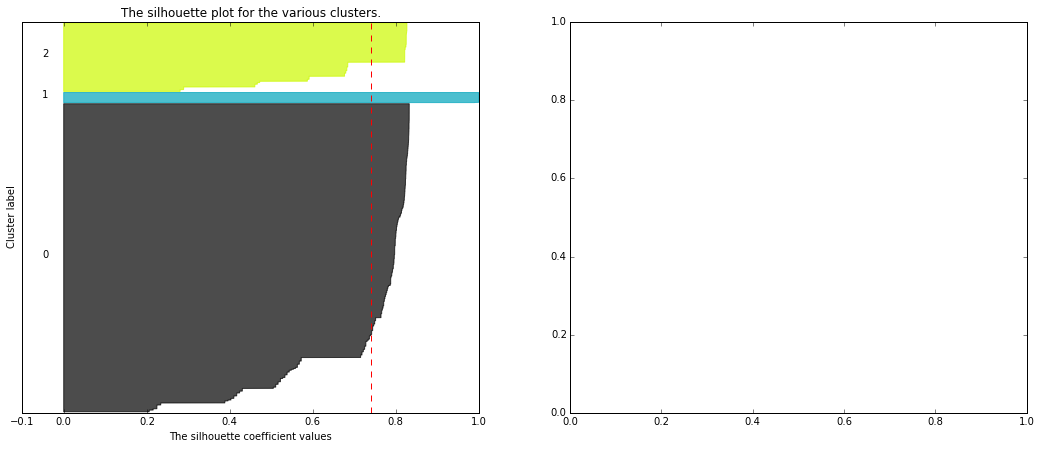

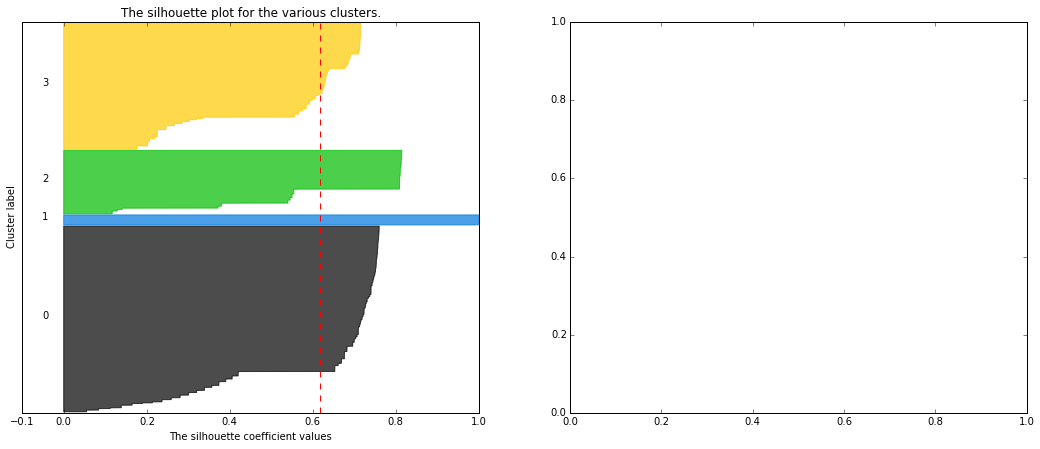

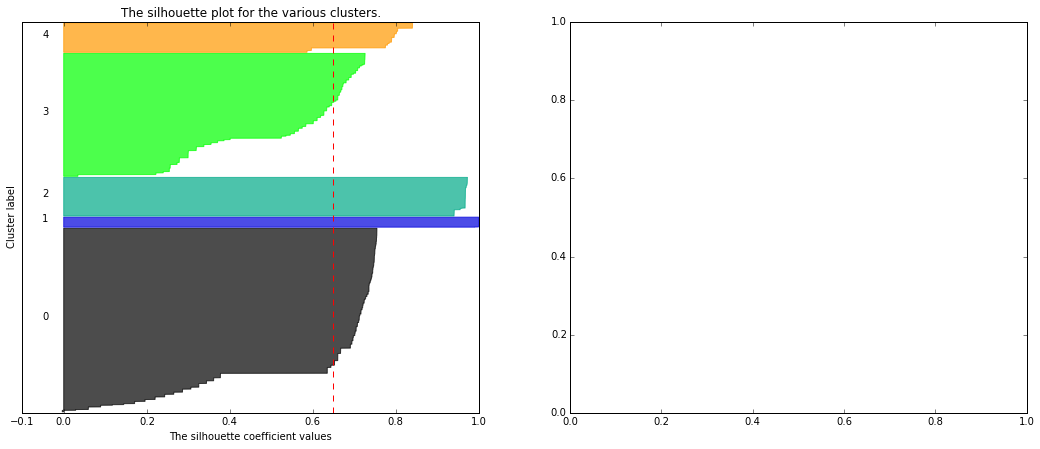

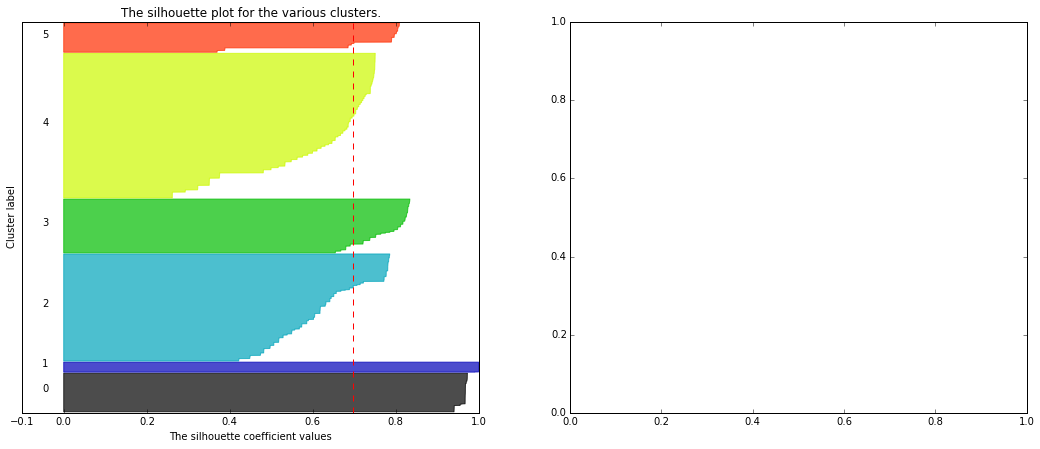

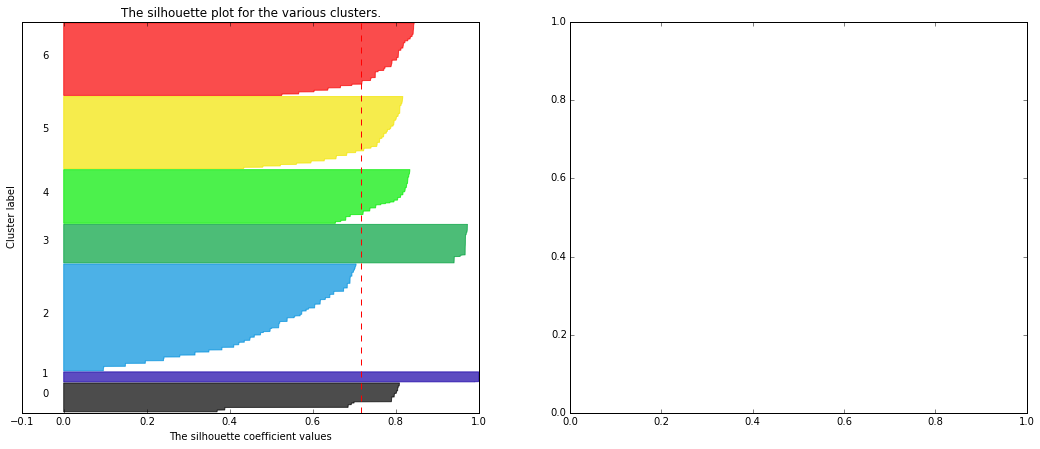

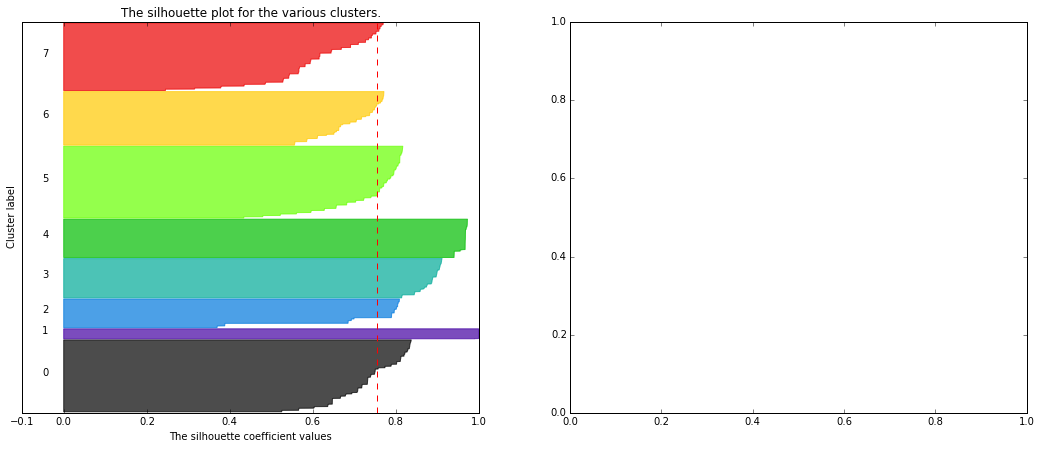

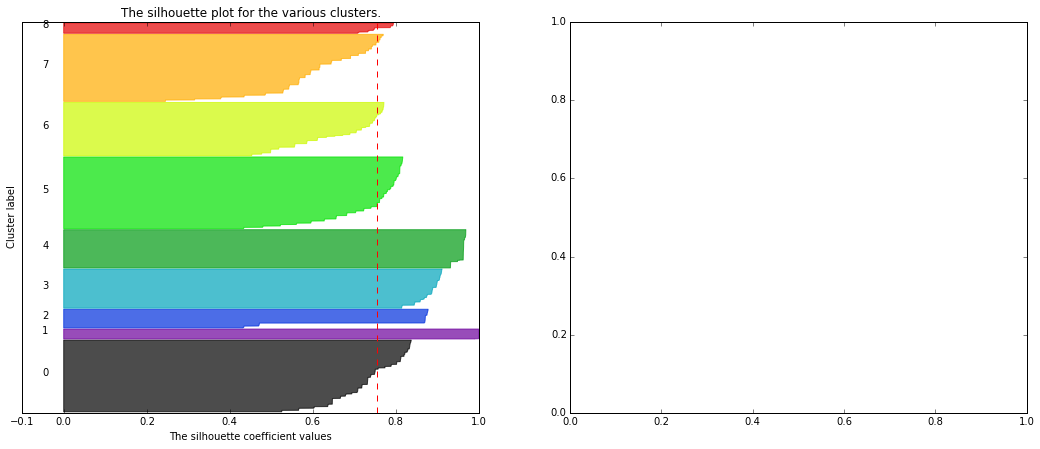

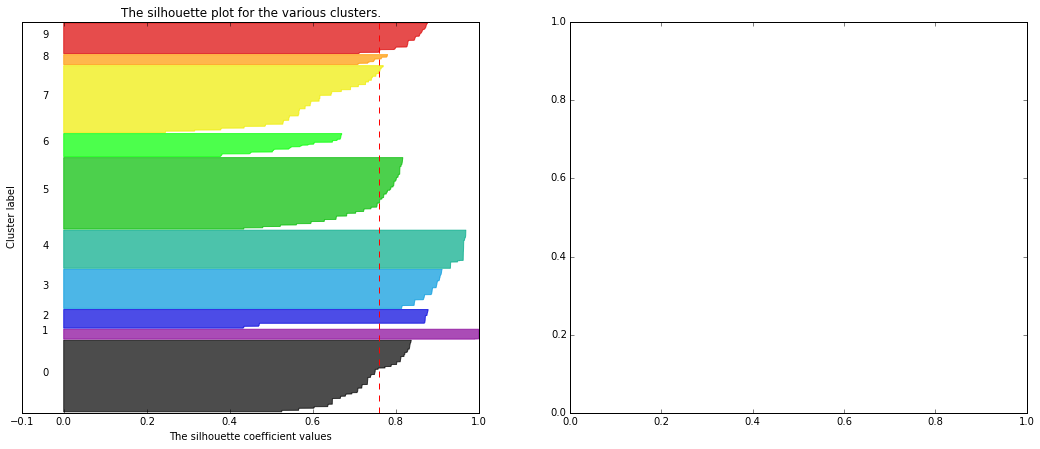

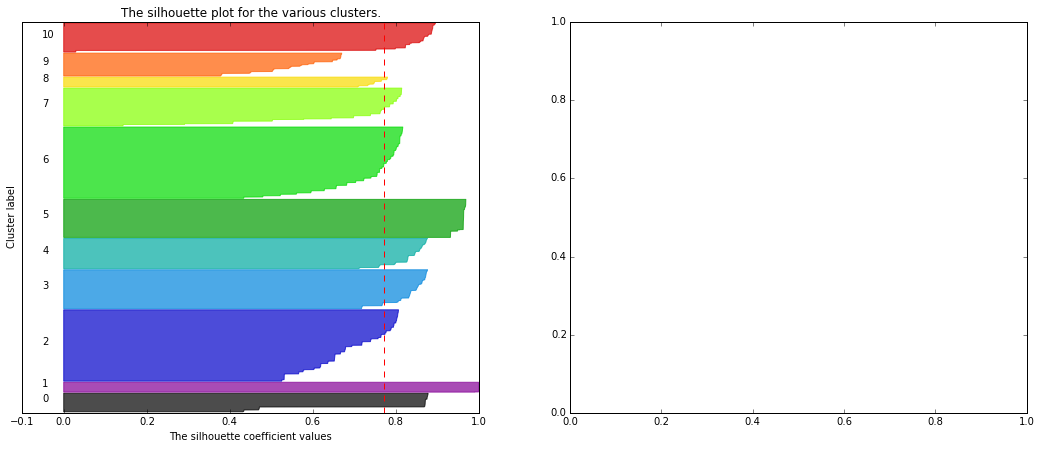

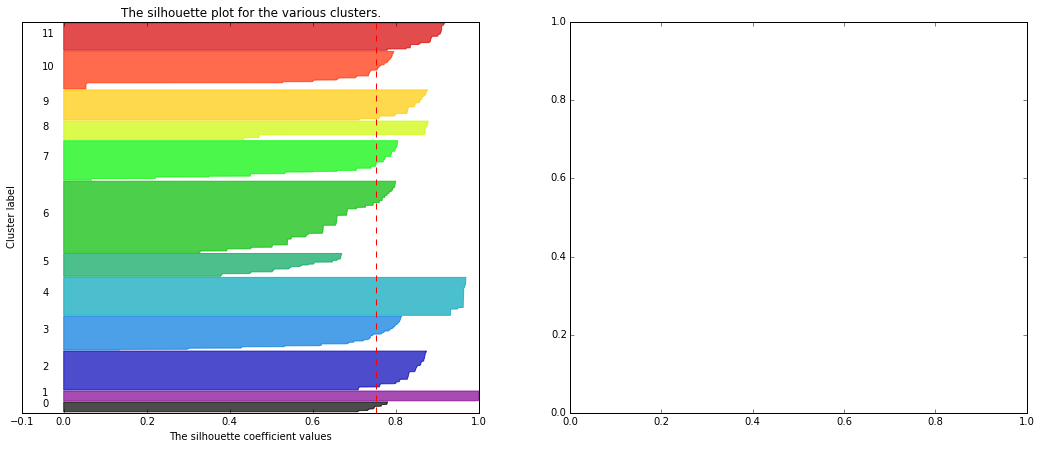

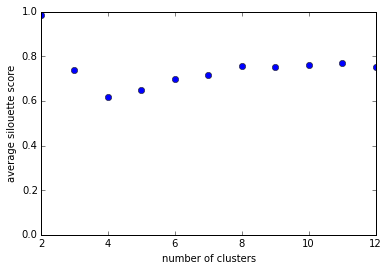

In [632]:
#Get dataframe ready for kmeans, but don't run it yet:
gg_k_df = modified_clean_and_run_kmeans(df, run_kmeans = False)
determine_k_silhoette(gg_k_df)

###Rerun K Means with 8 plots.  6 or eight look pretty good.

276 cluster # 0
1106 cluster # 1
555 cluster # 2
843 cluster # 3
541 cluster # 4
423 cluster # 5
33 cluster # 6
16 cluster # 7


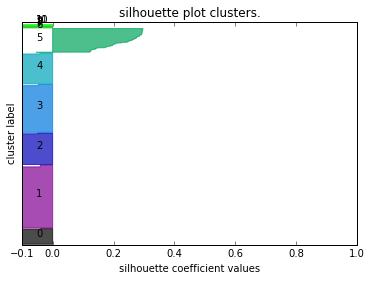

In [671]:
gg_k_df_v3 = modified_clean_and_run_kmeans(df, run_kmeans = False)

kmeans_v3, geoid_dict_v3, cluster_dict_v3 =run_k_means(gg_k_df_v3, 8)

In [673]:
for k, v in cluster_dict_v3.iteritems():
    print k,'\n number of neighborhoods: ', len(v), '\n', gg_k_df_v3[gg_k_df_v3['hrbin_'].isin(v)].mean(),'\n','\n'

0 
 number of neighborhoods:  276 
hrbin_                  inf
wkday_0            2.996603
wkday_1            1.158275
hrbin_morning      0.628438
hrbin_afternoon    1.481615
hrbin_evening      1.638302
hrbin_latenight    1.552292
hrbin_dawn         0.955831
dtype: float64 


1 
 number of neighborhoods:  1106 
hrbin_                  inf
wkday_0            0.224684
wkday_1            0.945403
hrbin_morning      0.150995
hrbin_afternoon    0.277451
hrbin_evening      0.866184
hrbin_latenight    0.290210
hrbin_dawn         0.225701
dtype: float64 


2 
 number of neighborhoods:  555 
hrbin_                  inf
wkday_0            1.421958
wkday_1            1.122578
hrbin_morning      1.299518
hrbin_afternoon    1.013666
hrbin_evening      1.023265
hrbin_latenight    1.029735
hrbin_dawn         0.745280
dtype: float64 


3 
 number of neighborhoods:  843 
hrbin_                  inf
wkday_0            1.427670
wkday_1            1.016922
hrbin_morning      0.000000
hrbin_afternoon    0.

In [674]:
features = gg_k_df_v3.columns.tolist()
top_centroids = kmeans_v3.cluster_centers_.argsort()[:,-1:-11:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print num
    print centroid
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid)), '\n'

top features for each cluster:
0
[0 4 5 3 1 6 2]
0: hrbin_, hrbin_afternoon, hrbin_evening, hrbin_morning, wkday_0, hrbin_latenight, wkday_1 

1
[1 4 5 3 6 0 2]
1: wkday_0, hrbin_afternoon, hrbin_evening, hrbin_morning, hrbin_latenight, hrbin_, wkday_1 

2
[0 2 1 5 4 3 6]
2: hrbin_, wkday_1, wkday_0, hrbin_evening, hrbin_afternoon, hrbin_morning, hrbin_latenight 

3
[0 5 1 4 3 6 2]
3: hrbin_, hrbin_evening, wkday_0, hrbin_afternoon, hrbin_morning, hrbin_latenight, wkday_1 

4
[3 1 0 5 2 6 4]
4: hrbin_morning, wkday_0, hrbin_, hrbin_evening, wkday_1, hrbin_latenight, hrbin_afternoon 

5
[5 1 0 6 2 4 3]
5: hrbin_evening, wkday_0, hrbin_, hrbin_latenight, wkday_1, hrbin_afternoon, hrbin_morning 

6
[6 0 1 3 4 5 2]
6: hrbin_latenight, hrbin_, wkday_0, hrbin_morning, hrbin_afternoon, hrbin_evening, wkday_1 

7
[0 4 5 3 2 1 6]
7: hrbin_, hrbin_afternoon, hrbin_evening, hrbin_morning, wkday_1, wkday_0, hrbin_latenight 



In [687]:
def plot_clusters(df, cluster_dict):
    '''
    INPUT: df - a dataframe formated for k-means analysis.
           cluster_dict - a dictionary with each cluster uncovered by
           k means as the key, and a list of associated geoids as the values.
    OUTPUT:  Plots the tweet rate over time for each cluster.'''
    
    num_clust = len(cluster_dict.keys())
    fig, axes = plt.subplots(nrows=numclust/2, ncols=2)
    
    for cluster_id, blocks in cluster_dict.iteritems():
        #set row and column indexes for each subplot
        if cluster_id < num_clust/2: 
            ci = 0 #column index
            ri = cluster_id #row index 
        else:
            ci = 1
            ri = cluster_id - num_clust/2
            
        dfk[dfk['geoid10'].isin(blocks)].plot(kind = 'box', 
            figsize = (20,12), ylim = (0,12),
            ax=axes[ri,ci]).set_title('cluster # ' + str(cluster_id))
   
    plt.tight_layout()
    plt.show()


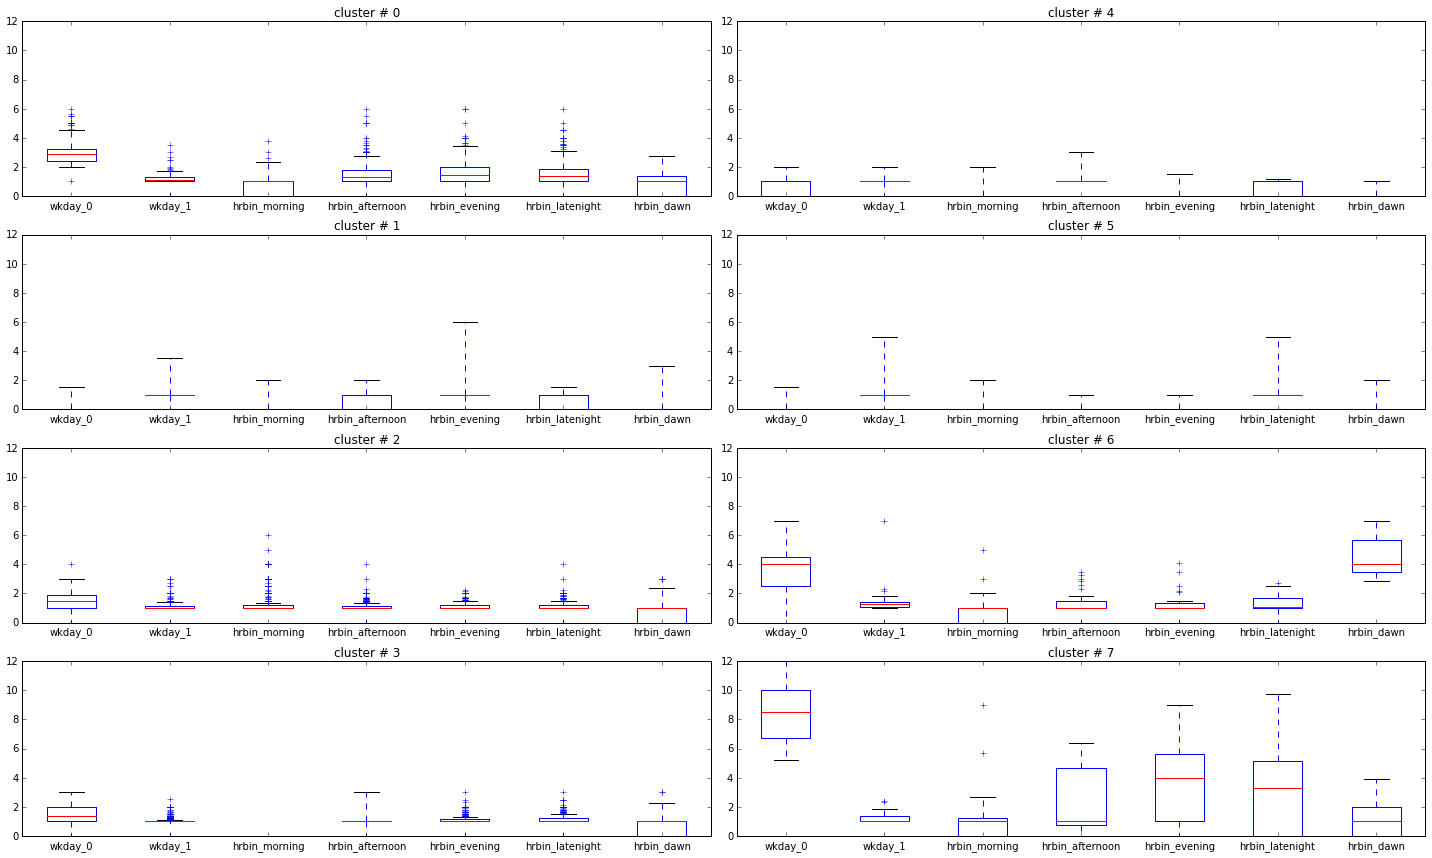

In [681]:
plot_clusters(gg_k_df_v3, cluster_dict_v3)

##Run With 6. I suspect 8 encourages overfitting

825 cluster # 0
510 cluster # 1
874 cluster # 2
42 cluster # 3
391 cluster # 4
1151 cluster # 5


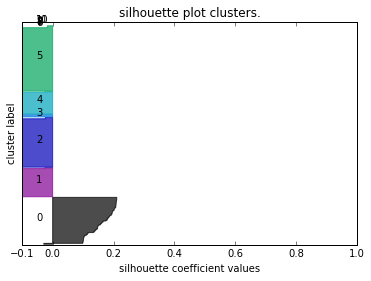

In [682]:
gg_k_df_v4 = modified_clean_and_run_kmeans(df, run_kmeans = False)

kmeans_v4, geoid_dict_v4, cluster_dict_v4 =run_k_means(gg_k_df_v4, 6)

In [684]:
for k, v in cluster_dict_v4.iteritems():
    print k,'\n number of neighborhoods: ', len(v), '\n', gg_k_df_v4[gg_k_df_v4['hrbin_'].isin(v)].mean(),'\n','\n'
features = gg_k_df_v4.columns.tolist()

top_centroids = kmeans_v4.cluster_centers_.argsort()[:,-1:-11:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print num
    print centroid
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid)), '\n'

0 
 number of neighborhoods:  825 
hrbin_                  inf
wkday_0            0.180000
wkday_1            0.977870
hrbin_morning      0.103030
hrbin_afternoon    0.261024
hrbin_evening      0.408788
hrbin_latenight    1.048997
hrbin_dawn         0.150303
dtype: float64 


1 
 number of neighborhoods:  510 
hrbin_                  inf
wkday_0            1.323434
wkday_1            1.111705
hrbin_morning      1.308141
hrbin_afternoon    0.980054
hrbin_evening      0.964035
hrbin_latenight    0.953744
hrbin_dawn         0.649791
dtype: float64 


2 
 number of neighborhoods:  874 
hrbin_                  inf
wkday_0            1.383643
wkday_1            0.997039
hrbin_morning      0.000000
hrbin_afternoon    0.962545
hrbin_evening      0.928038
hrbin_latenight    1.000677
hrbin_dawn         0.578178
dtype: float64 


3 
 number of neighborhoods:  42 
hrbin_                  inf
wkday_0            6.595270
wkday_1            1.266702
hrbin_morning      1.245724
hrbin_afternoon    2.15

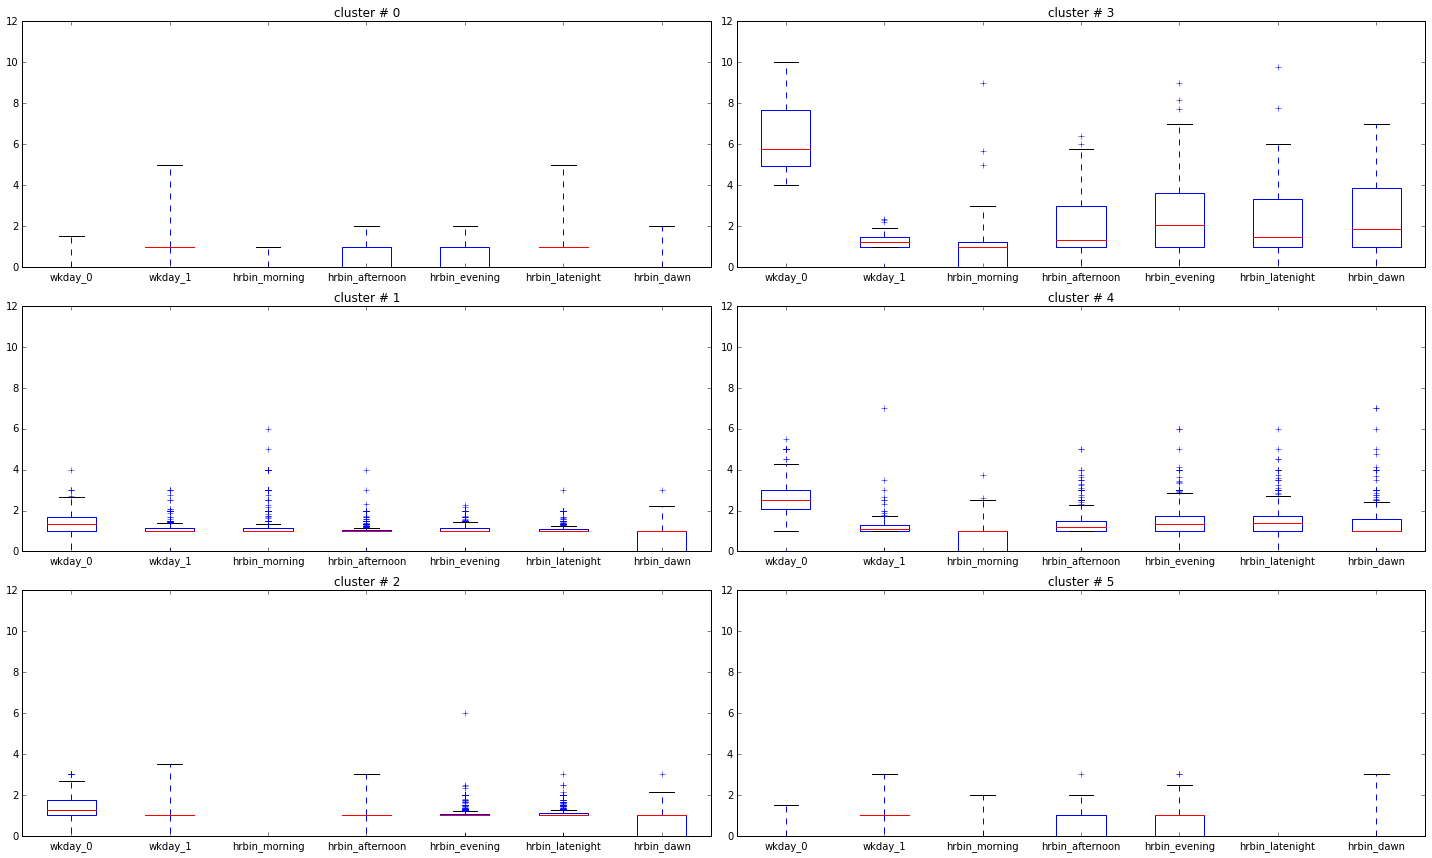

In [688]:
plot_clusters(gg_k_df_v4, cluster_dict_v4)

In [ ]:
3: 'high activity, especially on weekends'
4: 'medium activity. peaks on weekends and later in the day'
1: 'medium activity'
5: 'low activity, peaks during workday hours'
0: 'low activity, peaks in the afternoon thrugh late evening'
2: 'low activity, peaks on weekends and late night'


###save new clusters

In [743]:
with open('data/intermediate_data/kmeans/kmeans8_round_clustdict.csv', 'wb') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, cluster_dict_v3)
    w.writeheader()
    w.writerow(cluster_dict_v3)
with open('data/intermediate_data/kmeans/kmeans6_round_clustdict.csv', 'wb') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, cluster_dict_v4)
    w.writeheader()
    w.writerow(cluster_dict_v4)
    

In [744]:
with open('data/intermediate_data/kmeans/kmeans8_round_geodict.csv', 'wb') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, geoid_dict_v3)
    w.writeheader()
    w.writerow(geoid_dict_v3)
with open('data/intermediate_data/kmeans/kmeans6_round_feotdict.csv', 'wb') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, geoid_dict_v4)
    w.writeheader()
    w.writerow(geoid_dict_v4)

##Turn into geojasons WITH tokens. 

In [716]:
#add geocolumn 
gg_k_df_v4['geoid10'] = gg_k_df_v4['hrbin_'].apply(lambda x: x[1:])
#add tweetcount as average value
gg_k_df_v4['tweetcnt'] = gg_k_df_v4[['wkday_0', 'wkday_1','hrbin_morning','hrbin_afternoon','hrbin_evening','hrbin_latenight', 'hrbin_dawn']].mean(axis = 1)

#add geocolumn 
gg_k_df_v3['geoid10'] = gg_k_df_v3['hrbin_'].apply(lambda x: x[1:])
#add tweetcount as average value
gg_k_df_v3['tweetcnt'] = gg_k_df_v3[['wkday_0', 'wkday_1','hrbin_morning','hrbin_afternoon','hrbin_evening','hrbin_latenight', 'hrbin_dawn']].mean(axis = 1)

retrieve tweet data. re-run code seen in map_by_hour to get a list of tokens for each georegion

In [709]:
def retrieve_and_merge_tweet_data():
    '''Retrieves twitter geo data from SQL, and tweet text. 
    Returns the merged dataframe.'''
    #get SF Data From SQL
    df = mm.pipeline.retrieve_sql_tweets('tweets_with_geoV6')
    #get text data from picke
    dftxt = pd.read_csv('data/intermediate_data/json_tweets_in_df_twitokend.csv')
    df = df.set_index('id')
    dftxt = dftxt.set_index('id')
    dfall = df.join(dftxt).reset_index()
    dfall.drop('Unnamed: 0', 1, inplace = True)
    return dfall
df = retrieve_and_merge_tweet_data()

In [711]:
#FUSS WITH DATA TO GET IT FORMATED
hour_df = mm.pipeline.transform_timestamp(df, hour = True)
hour_df['tweetcnt'] = 1
#get a total count of tweets
hdf = hour_df.groupby(['geoid10']).agg(sum).reset_index().drop('id', 1)
#get a grouped sum of the words
hour_df_txt = hour_df.groupby(['geoid10'])['text'].apply(lambda x: ','.join(x)).reset_index()
#merge these two dataframes together
hdf['tokens'] = hour_df_txt['text']



#Make a generalized graph data script. Put this in there

In [7]:
#FOR NOW LET'S DO THE TOP 15 TOKENS 
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend([',', '-', ',', '"','?', '@', '&', ')',\
                  '(@', '|','i\'m', '(', ';','.',':','!','..','...',\
                  ',,,','S', 'C', 't', 'i', 'a', 'at'] )

def top_tokens(corpus_list, stopwrds=stopwords, number=10):
    '''Takes a list of tokens. Returns the top ten, unless a different number given.'''

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend([',', '-', ',', '"','?', '@', '&', ')',\
                  '(@', '|','i\'m', '(', ';','.',':','!','..','...',\
                  ',,,','S', 'C', 't','amp', 'i', 'a', 'at'] )
    #Checks to make sure the tokens are in a list, and not a string
    tokens = literal_eval(corpus_list)
    #If there are multiple tweets, flatten the list
    if type(tokens) == tuple:
        tokens =[item for sublist in tokens for item in sublist] 
        tokens = [re.sub(r'http.*$', '', item) for item in tokens]
    tokens = nltk.FreqDist(w.lower() for w in tokens if w not in stopwrds) 
    most_common = tokens.most_common(number)
    top_ten_string = ' '.join([tup[0] for tup in most_common])
    return top_ten_string

get the top 15 tokens for ever region. may turn into word cloud later. 

In [712]:
#######
'''functionalize this big block of df formatting
'''
top_ten = hdf.tokens.apply(top_tokens, number = 15)
#make a new column of the top tweets
hdf['top_ten'] = top_ten
#merge with shape geometry
###Retrieve the Shape Files for Each Block:
geodf = pd.read_csv('data/intermediate_data/sf_only_sql_shapes.csv')
#format the dataframe
geodf['geoid10'] = geodf.geoid10.astype('str')
geodf.drop('Unnamed: 0', axis = 1, inplace = True)
#set the index as the geoid
# need to alter the geoid10 column to merge with shape files
hdf['geoid10'] =hdf['geoid10'].apply(lambda x: x[1:])
#create a new dataframe 
hourlydf = pd.merge(geodfm, hdf, on='geoid10', how='outer')
#fill no tweets with a zero value
hourlydf.tweetcnt.fillna(0, inplace = True)
#drop empty hour columns
hourlydf.dropna(subset = ['hour'], inplace = True)

###FUNCTIONALIZE THIS FORMATTING FILE FOR GEOJASON
IMPORTANT!!!! ALL TOKENS ARE STILL IN HERE!!!!!!!!!!!!!!!!!!!

In [729]:
geo_k8 = gg_k_df_v3.merge(hourlydf, on='geoid10'  )

In [730]:
geo_k6 = gg_k_df_v4.merge(hourlydf, on='geoid10'  )

In [733]:
colors = ['#FF76BC', '#E1B700', '#91D100', '#00D8CC', '#56C5FF', '#1B58B8','#B81B6C' ,'#15992A' ]
#add color column based on values 
geo_k6['hexcolor'] =geo_k6["hrbin_"].apply(lambda x:colors[geoid_dict_v4[x]].upper())
geo_k6['cluster'] = geo_k6['hrbin_'].apply(lambda x: str(geoid_dict_v4[x]))   

geo_k8['hexcolor'] =geo_k8["hrbin_"].apply(lambda x:colors[geoid_dict_v3[x]].upper())
geo_k8['cluster'] = geo_k8['hrbin_'].apply(lambda x: str(geoid_dict_v3[x]))   

In [745]:
#save dataframes with all tokens for later analysis
geo_k6.to_pickle('data/intermediate_data/kmeans/k_6df.pkl')
geo_k8.to_pickle('data/intermediate_data/kmeans/k_8df.pkl')

In [737]:
def add_properties_geo(row):
    '''Creates the properties geoid, tweetcnt, cluster number'''
    geoid = row['geoid10']
    tweetrate = row['tweetcnt_x']
    hexcolor = row['hexcolor']
    cluster = row['cluster']
    top_ten  = row['top_ten']
    geo_json = {"type": "Feature", "geometry": json.loads(row['geometry']), "properties": {'geoid': geoid ,'tweetrate': tweetrate, 'top_ten': top_ten, 'cluster': cluster , 'hexcolor' : hexcolor}}
    return geo_json

def dataframe_to_geojson(df, outfilename):
    '''Takes in a dataframe with a count, geoid10, and list of tokens. Dumps it into a json geojason file'''
    df['geoid10'] = df['geoid10'].astype('str')
    df['geoid10'] = df['cluster'].astype('str')
    df["tweetcnt_x"] = df['tweetcnt_x'].astype('str')
    list_to_export = []
    for idx, row in df.iterrows():
        list_to_export.append(add_properties_geo(row))
    with open(outfilename, 'w') as outfile:
        json.dump(list_to_export, outfile)

In [739]:
#save dataframes with all tokens for later analysis
geo_k6.to_pickle('data/intermediate_data/kmeans/k_6df.pkl')
geo_k8.to_pickle('data/intermediate_data/kmeans/k_8df.pkl')

dataframe_to_geojson(geo_k6, 'map_making/clusters/data/clustergeo_k6.json')
dataframe_to_geojson(geo_k8, 'map_making/clusters/data/clustergeo_k8.json')

In [776]:
##Group Again For Text by Cluster

#group then again by cluster 
#get a mean so can get mean rate for each cluster 
geo_k6['tweetcnt_x'] =geo_k6['tweetcnt_x'].astype(float)
geo_k6_cluster = geo_k6.groupby(['cluster']).agg(np.mean).reset_index()
geo_k6_cluster_txt = geo_k6.groupby(['cluster'])['tokens'].apply(lambda x: ','.join(x)).reset_index()
geo_k6_cluster['tokens'] = geo_k6_cluster_txt['tokens']
geo_k6_cluster = geo_k6_cluster[['cluster','tweetcnt_x', 'tokens']]


#group then again by cluster 
#get a mean so can get mean rate for each cluster 
geo_k8['tweetcnt_x'] =geo_k8['tweetcnt_x'].astype(float)
geo_k8_cluster = geo_k8.groupby(['cluster']).agg(np.mean).reset_index()
geo_k8_cluster_txt = geo_k8.groupby(['cluster'])['tokens'].apply(lambda x: ','.join(x)).reset_index()
geo_k8_cluster['tokens'] = geo_k8_cluster_txt['tokens']
geo_k8_cluster = geo_k8_cluster[['cluster','tweetcnt_x', 'tokens']]

In [777]:
geo_k8_cluster.head()

,cluster,tweetcnt_x,tokens
0,0,1.487336,"[u'Acabo', u'de', u'publicar', u'una', u'foto'..."
1,1,0.425804,"[u'http://t.co/e3gnFSVTjW'],[u'#free', u'#birt..."
2,2,1.093714,"[u'I', u'want', u'one', u'for', u'my', u'birth..."
3,3,0.874484,"[u'The', u'other', u'day', u'at', u'the', u'Wa..."
4,4,0.412926,"[u'Sully', u'loves', u'treats', u'and', u'laps..."


In [808]:
top_ten = geo_k8_cluster.tokens.apply(top_tokens, number = 40)
#make a new column of the top tweets
geo_k8_cluster['top_ten'] = top_ten

top_ten = geo_k6_cluster.tokens.apply(top_tokens, number = 40)
#make a new column of the top tweets
geo_k6_cluster['top_ten'] = top_ten

##Question. Do tweets grouped in time carry a similar message?

In [813]:
cnt = 0
for row in geo_k8_cluster.top_ten:
    print 'Cluster#', cnt, '\n', row, '\n'
    cnt +=1

Cluster# 0 
san francisco ca … #sanfrancisco st #job request #hiring closed case amp the golden gate i i'm via bridge opened graffiti #careerarc #jobs street sidewalk iphone intersection cleaning resolved #virtualcacity #education park latest great #sf see just this day completed 

Cluster# 1 
request st closed case via opened amp san street francisco sidewalk intersection iphone … cleaning graffiti ave ca completed resolved i'm i android the park #sanfrancisco garbage abandoned blvd day illegal report sf unattended #sf abatement neglected new today postings 

Cluster# 2 
san francisco st request … closed case ca street via opened amp sidewalk the graffiti cleaning #sanfrancisco i'm iphone i intersection completed resolved #job #hiring sf #trndnl android #jobs #sf #careerarc ave trends ' mission bay place day just park 

Cluster# 3 
… san francisco outside lands ca music st request festival closed i'm case amp via opened #sanfrancisco i street #outsidelands the sidewalk day iphone graf

In [814]:
cnt = 0
for row in geo_k6_cluster.top_ten:
    print 'Cluster#', cnt, '\n', row, '\n'
    cnt +=1

Cluster# 0 
request closed st case via opened street sidewalk san amp francisco cleaning iphone … intersection graffiti ave completed ca resolved i'm i the android #sanfrancisco park abandoned blvd garbage day illegal #sf many new sf love postings just open311 pickup 

Cluster# 1 
san st francisco request closed case … ca street via opened amp sidewalk graffiti cleaning i'm intersection iphone #sanfrancisco completed resolved the i #job sf android #hiring ave #jobs #careerarc #sf mission market city day this new great good park 

Cluster# 2 
… san francisco outside lands ca music festival st request closed case amp i'm via opened street #outsidelands i #sanfrancisco the sidewalk iphone day graffiti cleaning intersection ave #sf #job #hiring resolved completed sf park #careerarc android one new #osl 

Cluster# 3 
… ca san #sanfrancisco francisco #job #hiring park at &amp; t the #careerarc #jobs i a latest st amp i'm request great opening union this we're graffiti square giants bay click

###Answer: More text analysis would be needed to uncover anything similar. It seems like there are particular words shared by all of the regions. 

####First, I pulled the .1% most common words across all of the corpus, and added them to the stop words to try to normalize for common words across all regions. I feel good about this after looking at the frequency of the words. 

In [851]:

corpus = geo_k8_cluster.tokens.values.tolist()
corpus = [item for sublist in corpus for item in sublist]
corpus = [item for sublist in corpus for item in sublist]
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in corpus if w not in stopwords) 
mostCommon= allWordExceptStopDist.most_common(55)
top_fifty = [tup[0] for tup in mostCommon]
stopwords.extend(top_fifty)

In [877]:
top_ten = geo_k8_cluster.tokens.apply(top_tokens, number = 40)
#make a new column of the top tweets
geo_k8_cluster['top_ten'] = top_ten

top_ten = geo_k6_cluster.tokens.apply(top_tokens, number = 40)
#make a new column of the top tweets
geo_k6_cluster['top_ten'] = top_ten

In [879]:
cnt = 0
for row in geo_k6_cluster.top_ten:
    print 'Cluster#', cnt, '\n', row, '\n'
    cnt +=1

Cluster# 0 
st opened street sidewalk san cleaning case closed francisco intersection ave graffiti ca i'm i the park abandoned blvd garbage illegal #sanfrancisco many sf love postings just open311 pickup it's today california geary vehicles unattended way neglected this best a 

Cluster# 1 
st san francisco ca street opened sidewalk closed case cleaning graffiti i'm intersection the i #sanfrancisco sf ave #hiring #careerarc #job #jobs mission market city this good just it's park report house today abatement #veterans us a ❤ garbage photo 

Cluster# 2 
san francisco outside lands ca music st festival i'm opened i street the sidewalk graffiti intersection cleaning closed case #sanfrancisco ave sf day #careerarc #hiring #outsidelands park #osl coffee #veterans #hospitality just love good this today it's outside_lands us 2 

Cluster# 3 
ca san francisco #sanfrancisco #hiring park at t the #careerarc #job #jobs i a st i'm opening union this square we're giants click #sfgiants ferry bay open

In [880]:
cnt = 0
for row in geo_k8_cluster.top_ten:
    print 'Cluster#', cnt, '\n', row, '\n'
    cnt +=1

Cluster# 0 
san francisco ca st #sanfrancisco the #hiring golden i gate i'm opened #careerarc bridge #job graffiti #jobs closed case street sidewalk intersection cleaning #virtualcacity #education park just this california mission we're sf opening click pier city photo ave posted want 

Cluster# 1 
st opened san street francisco sidewalk intersection cleaning case closed ave graffiti ca i'm i the park garbage abandoned blvd illegal report sf unattended #sanfrancisco abatement neglected today postings requests get california vehicles love market like my this way #careerarc 

Cluster# 2 
san francisco st ca street opened the sidewalk closed case cleaning i'm graffiti i intersection #sanfrancisco #trndnl sf #hiring #careerarc ave trends ' #job mission #jobs place just francisco's bay like hours this park city &gt; #veterans market beach good 

Cluster# 3 
san francisco outside ca lands st music festival i'm opened i street the sidewalk #sanfrancisco intersection graffiti closed case clean

In [ ]:
#For 8 clusters:
Summary for Cluster 7:
    - attnt major influence
    - also soma eats, 
    - a few job posting
    - rest are allerts of grafitti and cleaning
    
Cluster 0 : caputres a lot of parks. Mkae sense high level of activity overall. also downtown. high daytime use.
    


#Extra Formatting

geo_k6_cluster

In [5]:
df = pd.read_pickle('data/intermediate_data/kmeans/k_6df.pkl')

In [12]:
df.head()

,hrbin_,wkday_0,wkday_1,hrbin_morning,hrbin_afternoon,hrbin_evening,hrbin_latenight,hrbin_dawn,geoid10,tweetcnt_x,geometry,hour,tweetcnt_y,tokens,top_ten,hexcolor,cluster
0,060750101001000,2.416667,1.111111,1,1.566667,1.497619,1.628571,1.000000,60750101001000,1.46009070295,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",945,71,"[u'Acabo', u'de', u'publicar', u'una', u'foto'...",… san pier francisco 39 fishermens wharf #san...,#56C5FF,4
1,060750101001001,4.580645,1.840909,1,2.148681,3.529038,3.584762,1.819597,60750101001001,2.64337614383,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",8602,718,"[u'a', u""gentleman's"", u'quarters', u'at', u'#...",san pier alcatraz 39 francisco … ca island i'...,#00D8CC,3
2,060750101001002,0.000000,1.000000,0,0.000000,0.000000,1.000000,0.000000,60750101001002,0.285714285714,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",3,1,"[u'Remember', u'why', u'you', u'started', u'ht...",started https://t.co/7dfeh4uoas remember,#FF76BC,0
3,060750101001004,2.840000,1.445455,1,1.325000,1.812762,2.202626,1.232143,60750101001004,1.69399798614,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",2805,261,"[u'My', u'last', u'#SFO', u'post', u'\U0001f62...",wharf san fisherman's … francisco fishermen's...,#56C5FF,4
4,060750101001005,1.333333,1.000000,1,1.500000,1.500000,1.000000,1.000000,60750101001005,1.19047619048,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",140,11,"[u'I', u'want', u'one', u'for', u'my', u'birth...",fisherman's wharf grotto pompei's restaurant ...,#E1B700,1


In [10]:
import re

In [11]:
top_ten = df.tokens.apply(top_tokens, number = 40)
#make a new column of the top tweets
df['top_ten'] = top_ten

In [13]:
df.cluster[0]

'4'

In [15]:
add_labels = {
'3': 'high activity, especially on weekends',
'4': 'medium activity. peaks on weekends and later in the day',
'1': 'medium activity',
'5': 'low activity, peaks during workday hours',
'0': 'low activity, peaks in the afternoon thrugh late evening',
'2': 'low activity, peaks on weekends and late night'
 }

In [16]:
df['label'] = df.cluster.apply(lambda x: add_labels[x])

In [34]:
df['clusters'] = df.cluster.apply(lambda x: new_numbers[x])

In [33]:
new_numbers = {'0' :'4', '1':'2', '2':'5', '3':'0', '4':'1', '5':'3'}

In [24]:
df.hrbin_[0]

'060750101001000'

In [26]:
odd_ids = ['060750601001016', '060750179021003','060759901000003', '060759901000002', '060750179021000','060750601001000', '060759804011003', '060750201001001']
df = df[~df['hrbin_'].isin(odd_ids)]
df['cluster_tph'] = df.tweetcnt_x.astype(float).apply(lambda x: format(x, '.2f'))

In [32]:
df[['clusters', 'label']]

,clusters,label
0,1,medium activity. peaks on weekends and later i...
1,0,"high activity, especially on weekends"
2,3,"low activity, peaks in the afternoon thrugh la..."
3,1,medium activity. peaks on weekends and later i...
4,4,medium activity
5,4,medium activity
6,4,medium activity
7,1,medium activity. peaks on weekends and later i...
8,2,"low activity, peaks during workday hours"
9,4,medium activity


In [35]:
def add_properties_geo(row):
    '''Creates the properties geoid, tweetcnt, cluster number'''
    geoid = row['geoid10']
    tweetrate = row['cluster_tph']
    hexcolor = row['hexcolor']
    label = row['label']
    clusters = row['clusters']
    top_ten  = row['top_ten']
    geo_json = {"type": "Feature", "geometry": json.loads(row['geometry']), "properties": {'geoid': geoid ,'tweetrate': tweetrate, 'top_ten': top_ten, 'clusters': clusters , 'hexcolor' : hexcolor, 'label': label}}
    return geo_json

def dataframe_to_geojson(df, outfilename):
    '''Takes in a dataframe with a count, geoid10, and list of tokens. Dumps it into a json geojason file'''
    df['geoid10'] = df['geoid10'].astype('str')
    df['clusters'] = df['clusters'].astype('str')
    df["cluster_tph"] = df['cluster_tph'].astype('str')
    list_to_export = []
    for idx, row in df.iterrows():
        list_to_export.append(add_properties_geo(row))
    with open(outfilename, 'w') as outfile:
        json.dump(list_to_export, outfile)

In [36]:
dataframe_to_geojson(df, '../app/data/kmeans6_geo.json')